In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# HS 데이터 추출

In [2]:
data = pd.read_csv('./211104/211104 kpeb1.csv', parse_dates = True)

In [3]:
data

,datetime,HeatPump(W),Total_Consumption(W),Total_Production(W),Pv1_Supply(W),Pv2_Supply(W)
0,2021-06-16 13:33:00,0,0,0,0,0
1,2021-06-16 13:34:00,0,0,0,0,0
2,2021-06-16 13:35:00,0,0,0,0,0
3,2021-06-16 13:36:00,0,0,0,0,0
4,2021-06-16 13:37:00,0,0,0,0,0
...,...,...,...,...,...,...
181551,2021-11-04 16:28:00,197,8995,1797,617,1180
181552,2021-11-04 16:29:00,197,10006,1726,601,1125
181553,2021-11-04 16:30:00,195,10279,1666,585,1082
181554,2021-11-04 16:31:00,196,10606,1614,570,1044


In [4]:
all_features = data.columns.tolist()
print(all_features)

['datetime', 'HeatPump(W)', 'Total_Consumption(W)', 'Total_Production(W)', 'Pv1_Supply(W)', 'Pv2_Supply(W)']


In [5]:
df_kpeb1 = pd.DataFrame()
df_kpeb1['Time'] = data['datetime']
df_kpeb1['Cons_kpeb1(W)'] = data['Total_Consumption(W)']
df_kpeb1['Prod_kpeb1(W)'] = data['Total_Production(W)']

df_kpeb1.head()


,Time,Cons_kpeb1(W),Prod_kpeb1(W)
0,2021-06-16 13:33:00,0,0
1,2021-06-16 13:34:00,0,0
2,2021-06-16 13:35:00,0,0
3,2021-06-16 13:36:00,0,0
4,2021-06-16 13:37:00,0,0


In [6]:
df_kpeb1['Time'] = pd.to_datetime(df_kpeb1['Time'])

In [7]:
df_kpeb1=df_kpeb1[(df_kpeb1['Time']>='2021-09-13 00:00:00')]
df_kpeb1=df_kpeb1[(df_kpeb1['Time']<'2021-11-04 00:00:00')]

In [8]:
df_kpeb1 = df_kpeb1[df_kpeb1['Cons_kpeb1(W)']< 35000]

In [9]:
df_kpeb1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65378 entries, 115181 to 180562
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Time           65378 non-null  datetime64[ns]
 1   Cons_kpeb1(W)  65378 non-null  int64         
 2   Prod_kpeb1(W)  65378 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.0 MB


In [10]:
df_kpeb1['Cons_kpeb1(W)'] = df_kpeb1['Cons_kpeb1(W)'].astype(float)
df_kpeb1['Prod_kpeb1(W)'] = df_kpeb1['Prod_kpeb1(W)'].astype(float)

In [11]:
df_kpeb1=df_kpeb1.set_index('Time')
df_kpeb1=df_kpeb1.resample('1T').mean()

In [12]:
df_kpeb1['Cons_acc_kpeb1(Wh)'] = df_kpeb1['Cons_kpeb1(W)'].cumsum()*60/3600
df_kpeb1['Prod_acc_kpeb1(Wh)'] = df_kpeb1['Prod_kpeb1(W)'].cumsum()*60/3600

In [13]:
df_kpeb1['denominator'] = df_kpeb1.loc[:,['Cons_kpeb1(W)','Prod_kpeb1(W)']].min(axis=1)
df_kpeb1['denominator_acc'] = df_kpeb1.loc[:,['Cons_acc_kpeb1(Wh)','Prod_acc_kpeb1(Wh)']].min(axis=1)

In [14]:
df_kpeb1['SCF'] = df_kpeb1['denominator']/df_kpeb1['Prod_kpeb1(W)']
df_kpeb1['LCF'] = df_kpeb1['denominator']/df_kpeb1['Cons_kpeb1(W)']

In [15]:
df_kpeb1['SCF_acc'] = df_kpeb1['denominator_acc']/df_kpeb1['Prod_acc_kpeb1(Wh)']
df_kpeb1['LCF_acc'] = df_kpeb1['denominator_acc']/df_kpeb1['Cons_acc_kpeb1(Wh)']
df_kpeb1['self_sustain'] = df_kpeb1['Prod_acc_kpeb1(Wh)']/df_kpeb1['Cons_acc_kpeb1(Wh)']
df_kpeb1['Avg_SCF&LCF'] = (df_kpeb1['SCF_acc']+df_kpeb1['LCF_acc'])/2

In [16]:
df_kpeb1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74880 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Freq: T
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cons_kpeb1(W)       65378 non-null  float64
 1   Prod_kpeb1(W)       65378 non-null  float64
 2   Cons_acc_kpeb1(Wh)  65378 non-null  float64
 3   Prod_acc_kpeb1(Wh)  65378 non-null  float64
 4   denominator         65378 non-null  float64
 5   denominator_acc     65378 non-null  float64
 6   SCF                 30126 non-null  float64
 7   LCF                 65373 non-null  float64
 8   SCF_acc             65028 non-null  float64
 9   LCF_acc             65378 non-null  float64
 10  self_sustain        65378 non-null  float64
 11  Avg_SCF&LCF         65028 non-null  float64
dtypes: float64(12)
memory usage: 7.4 MB


In [17]:
df_kpeb1

,Cons_kpeb1(W),Prod_kpeb1(W),Cons_acc_kpeb1(Wh),Prod_acc_kpeb1(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,
2021-09-13 00:00:00,5695.0,0.0,9.491667e+01,0.000000e+00,0.0,0.000000e+00,NaN,0.0,NaN,0.000000,0.000000,NaN
2021-09-13 00:01:00,5284.0,0.0,1.829833e+02,0.000000e+00,0.0,0.000000e+00,NaN,0.0,NaN,0.000000,0.000000,NaN
2021-09-13 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-13 00:03:00,5551.0,0.0,2.755000e+02,0.000000e+00,0.0,0.000000e+00,NaN,0.0,NaN,0.000000,0.000000,NaN
2021-09-13 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,6076.0,0.0,8.487453e+06,5.437472e+06,0.0,5.437472e+06,NaN,0.0,1.0,0.640648,0.640648,0.820324
2021-11-03 23:56:00,6179.0,0.0,8.487556e+06,5.437472e+06,0.0,5.437472e+06,NaN,0.0,1.0,0.640640,0.640640,0.820320
2021-11-03 23:57:00,6468.0,0.0,8.487664e+06,5.437472e+06,0.0,5.437472e+06,NaN,0.0,1.0,0.640632,0.640632,0.820316


In [18]:
df_kpeb1.to_csv('./211109_kpeb1.csv')

# Scatter plotting

KeyError: 'Time'

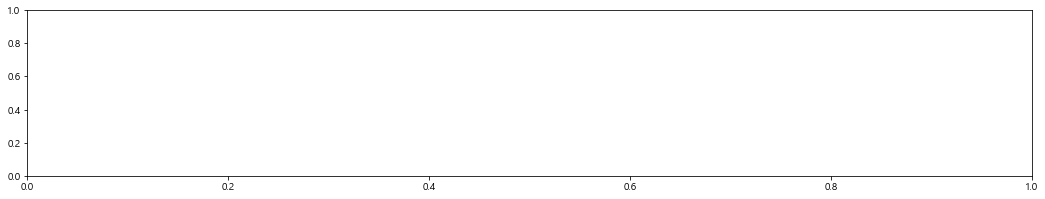

In [19]:
fig, ax = plt.subplots(figsize=(18,50))


for i in range(len(df_kpeb1.columns)):
    plt.subplot(len(df_kpeb1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
#     plt.xlim(pd.Timestamp('2021-04-01'), pd.Timestamp('2021-11-30'))
    name = df_kpeb1.columns[i]
    plt.scatter(x=df_kpeb1['Time'], y=df_kpeb1[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()

# Line plotting

In [ ]:
df_kpeb1=df_kpeb1.set_index('Time')

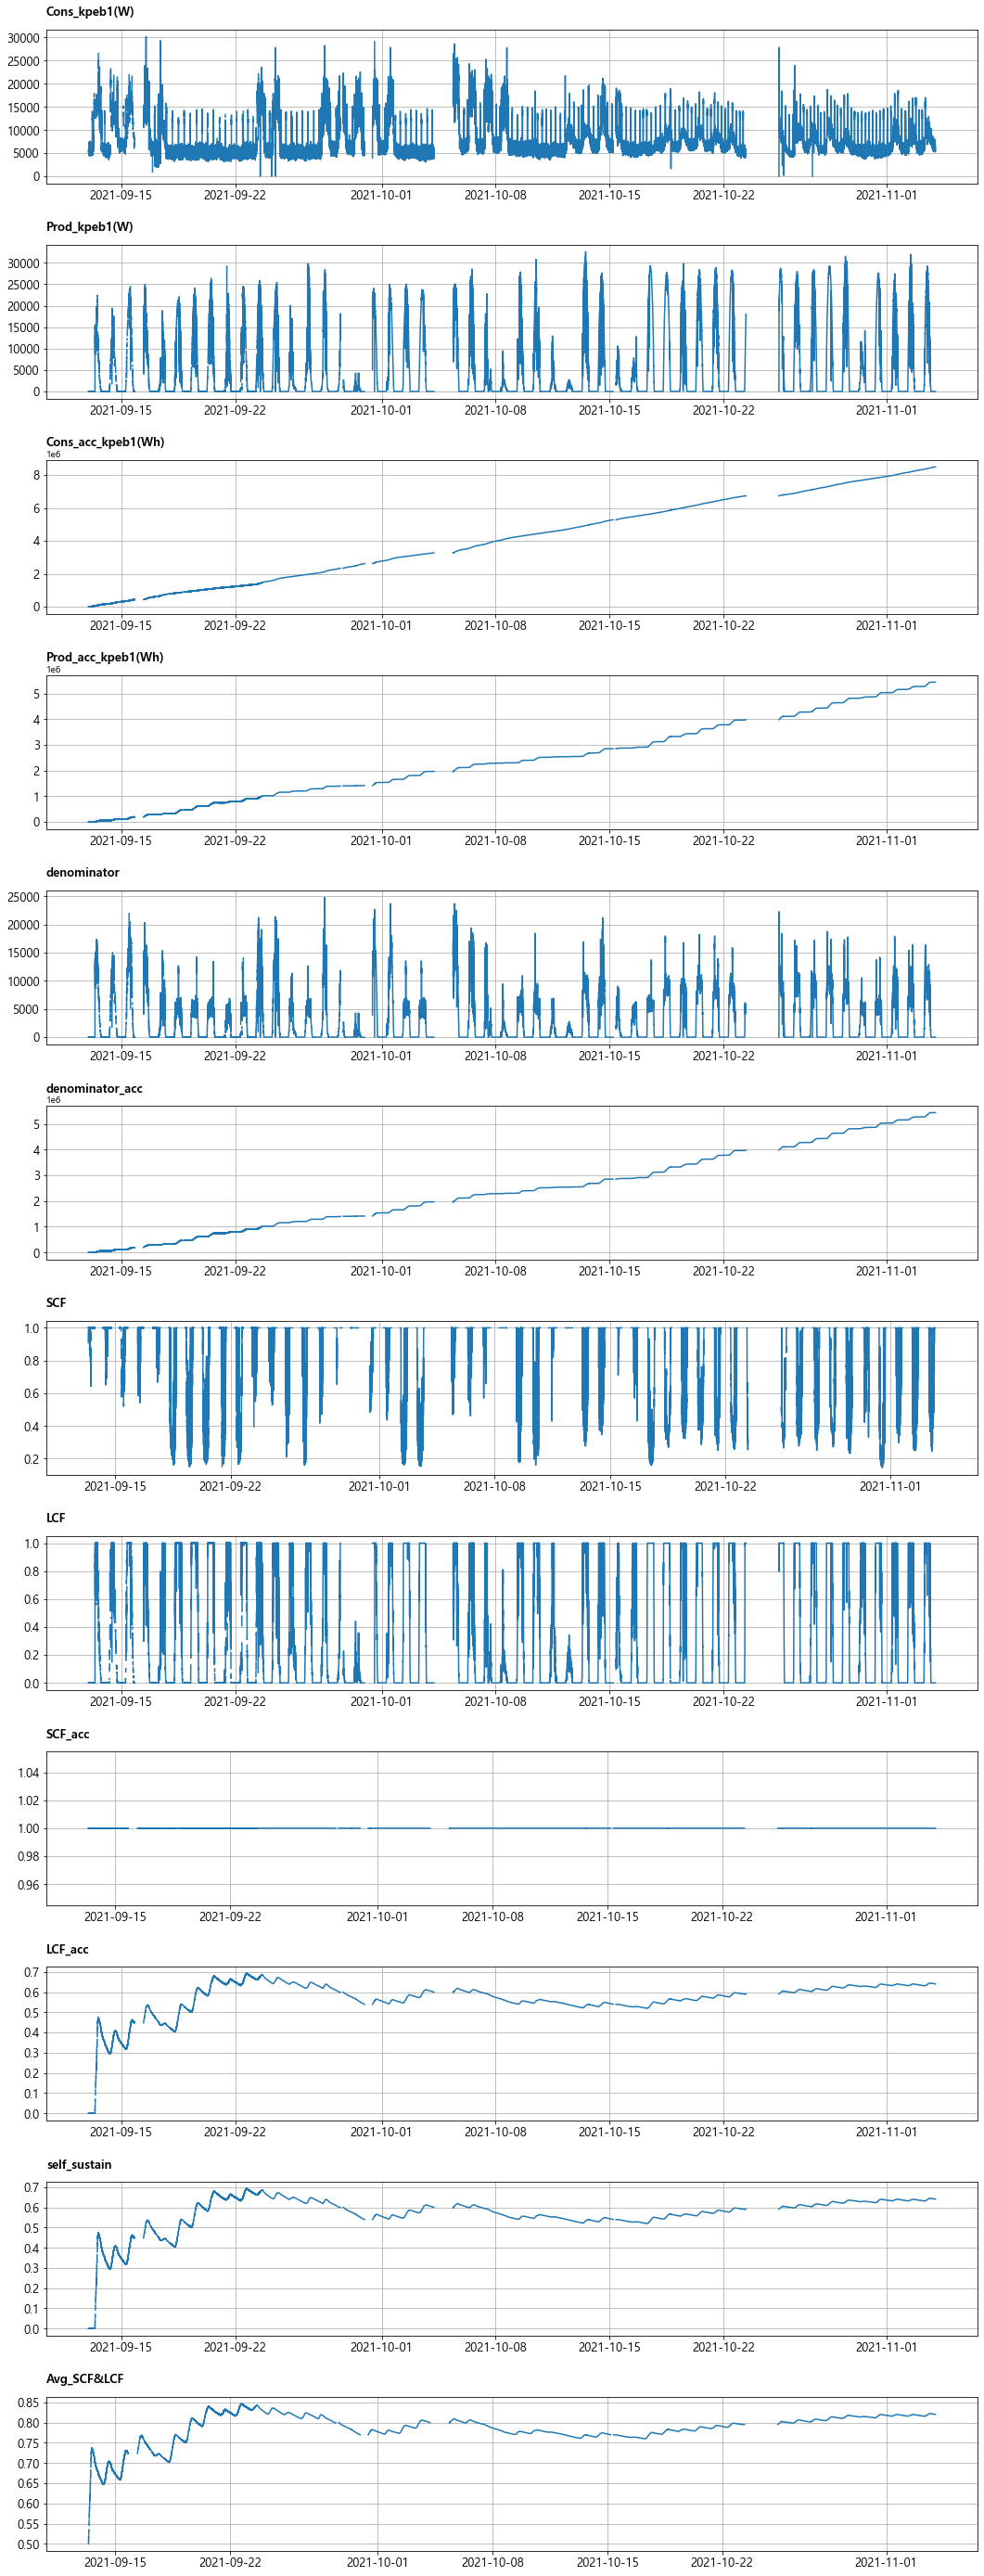

In [20]:
fig, ax = plt.subplots(figsize=(18,50))

for i in range(len(df_kpeb1.columns)):
    plt.subplot(len(df_kpeb1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpeb1.columns[i]
    plt.plot(df_kpeb1[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
#     plt.xlim(pd.Timestamp('2020-11-01'), pd.Timestamp('2021-08-31'))    
    plt.grid(True)
plt.show()
fig.tight_layout()